Imports

In [26]:
from paths import *
from src.SERS_dataset import IterDataset
from src.generate_data2 import pseudoVoigtSimulatorTorch
from sklearn.preprocessing import StandardScaler
import torch 
from matplotlib import pyplot as plt
import numpy as np
from src.plotting.save_plot import save_plot
import dill
import io
import time
# matplotlib style seaborn-whitegrid
plt.style.use('seaborn-whitegrid')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
cuda = torch.cuda.is_available()

C:\Users\andre\AppData\Local\Temp\ipykernel_10556\4169636792.py:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


Define helper function to calculate pseudo-voigt

In [27]:
def f(a=None, c=None):
    ps = pseudoVoigtSimulatorTorch(500)
    peaks = c if c else torch.tensor([250/500], device=device)
    gamma = torch.tensor([20], device=device) 
    eta = torch.tensor([0.5], device=device)
    alpha = a if a else torch.tensor([5], device=device)
    pv = ps.decoder(peaks, gamma, eta, alpha, wavenumber_normalize=True, height_normalize=True, batch_size=1)
    return pv.flatten()


Define data simulator

In [28]:
ps = pseudoVoigtSimulatorTorch(500)
generator = ps.predefined_generator(3)

Do gradient descent with different starting values on 100 different data samples

In [37]:
data = {}
batch_size = 10
for bn in range(batch_size):
    x, y = next(generator)
    true_a = x[3].item()
    true_c = x[0].item()

    values = []
    good_estimate = []
    mses = []
    times = []
    steps_to_converge = []
    ac = []
    aer = np.linspace(0.01, 10, 5)
    cs = np.linspace(0.01, 1, 10)

    # make tuples of all combinations of a and c
    ac = [(a, c) for a in aer for c in cs]

    converged = [False]*len(ac)

    for j, (a_,c_) in enumerate(ac): 
        time_start = time.time()

        a = torch.tensor([a_], requires_grad=True, device=device)
        c = torch.tensor([c_], requires_grad=True, device=device)
        i= 0
        vals = []
        while True:
            x_hat = f(a, c)
            MSE = torch.mean((x - x_hat)**2)
            mses.append(MSE.item())
            MSE.backward()

            # print(MSE.item())


            if i > 1 and abs(mses[-1] - mses[-2]) < 1e-5:
            # if torch.abs(a.grad) < 1e-5 and c.grad < 1e-3:
                # print("Converged at i: ", i)
                converged[j] = True
                break

            with torch.no_grad():
                # print("alpha: ", a.grad.item(), "c: ", c.grad.item()/500)
                a -= a.grad
                c -= c.grad/500
                c.grad.zero_()
                a.grad.zero_()
            vals.append((a.item(), c.item()))

            if i > 1000:
                break

            i +=1
        
        time_end = time.time()
        # print("a: ", a.item(), "c: ", c.item())
        times.append(time_end - time_start)
        steps_to_converge.append(i)
        good_estimate.append(abs(a.item() - y[3].item()) < 0.1 and abs(c.item() - y[0].item()/500) < 0.01)
        values.append(vals)

    if bn % 10 == 0:
        print("Batch: ", bn)
    data[(true_a, true_c)] = {'values': values, 'good_estimate': good_estimate, 'mses': mses, 
                              'times': times, 'steps_to_converge': steps_to_converge, 
                              'converged': converged}

Batch:  0


Evaluate results

In [46]:
sum(good_estimate)/len(good_estimate)

avg_good_estimate = []
avg_time = []
avg_good_times = []
avg_steps = []
avg_good_steps = []
avg_converged = []
avg_converged_mses = []

for key, val in data.items():
    avg_good_estimate.append(sum(val['good_estimate'])/len(val['good_estimate'])) 
    times = val['times']
    good_times = [t for (t, g) in zip(times, good_estimate) if g]
    converged_mses = [m for (m, c) in zip(val['mses'], val['converged']) if c]

    avg_time.append(np.mean(times))

    # calc average good times, but disregard any empty list
    if len(good_times) > 0:
        avg_good_times.append(np.mean(good_times))
    avg_steps.append(np.mean(val['steps_to_converge']))

    good_steps = [s for (s, g) in zip(val['steps_to_converge'], good_estimate) if g]
    if len(good_steps) > 0:

        avg_good_steps.append(np.mean(good_steps))
    avg_converged.append(sum(val['converged'])/len(val['converged']))

    avg_converged_mses.append(np.mean(converged_mses))

print("Percentage of good estimates: ", np.mean(avg_good_estimate))
print("Mean time to converge: ", np.mean(avg_time))
print("Mean time to converge for good estimates: ", np.mean(avg_good_times))
print("Mean steps to converge: ", np.mean(avg_steps))
print("Mean steps to converge for good estimates: ", np.mean(avg_good_steps))
print("How many converged?: ", np.mean(avg_converged))
print("Mean MSE for converged: ", np.mean(avg_converged_mses))

print("\def\percentGood{", np.mean(avg_good_estimate)*100, "}", sep="")
print("\def\percentConverged{", np.mean(avg_converged)*100, "}", sep="")
print("\def\meanTimeToConverge{", np.round(np.mean(avg_time),3), "}", sep="")
print("\def\meanTimeToConvergeGood{", np.round(np.mean(avg_good_times),3), "}", sep="")
print("\def\meanStepsToConverge{", np.round(np.mean(avg_steps),0), "}", sep="")
print("\def\meanStepsToConvergei{", np.round(np.mean(avg_steps)-1,0), "}", sep="")
print("\def\meanStepsToConvergeGood{", np.round(np.mean(avg_good_steps),0), "}", sep="")
print("\def\meanStepsToConvergeGoodi{", np.round(np.mean(avg_good_steps)-1,0), "}", sep="")
print("\def\meanMSEConverged{", np.round(np.mean(avg_converged_mses),3), "}", sep="")


Percentage of good estimates:  0.122
Mean time to converge:  0.7003793649673462
Mean time to converge for good estimates:  0.4280412197113037
Mean steps to converge:  347.46799999999996
Mean steps to converge for good estimates:  217.56666666666666
How many converged?:  0.708
Mean MSE for converged:  2.715078205988266
\def\percentGood{12.2}
\def\percentConverged{70.8}
\def\meanTimeToConverge{0.7}
\def\meanTimeToConvergeGood{0.428}
\def\meanStepsToConverge{347.0}
\def\meanStepsToConverge{346.0}
\def\meanStepsToConvergeGood{218.0}
\def\meanMSEConverged{2.715}


In [34]:
mses

[5.6660877004193235,
 5.6659103024993716,
 5.665762686658978,
 5.665639850992935,
 5.665537638044244,
 5.665452589803766,
 5.665381828619744,
 5.665322959019848,
 5.665273986533084,
 5.665233250412392,
 5.665199367778246,
 5.665171187182206,
 5.66514774996362,
 5.665128258069193,
 5.665112047241877,
 5.665098564676858,
 5.665087350397621,
 5.665078021732239,
 5.665902050119308,
 5.664948383171395,
 5.664230249870848,
 5.663687703136054,
 5.663276018037059,
 5.662961834315163,
 5.662720276528184,
 5.6625328021578705,
 5.662385593423065,
 5.662268355773328,
 5.662173420700875,
 5.6620951739407115,
 5.66203011536929,
 5.661974121477608,
 5.661924833157526,
 5.661880498019515,
 5.661839813968929,
 5.661801813100564,
 5.6617657755536355,
 5.66173116561082,
 5.661697584301609,
 5.661664914447138,
 5.661633000950466,
 5.661601380937783,
 5.6615699413088585,
 5.661538597717242,
 5.661507287133003,
 5.661475962345201,
 5.66144458789551,
 5.661413184283971,
 5.661381923412567,
 5.6613505324482,


Save to file 

In [20]:
baseline_results_dir = os.path.join(results_dir, '0_baseline')

with open(f'{baseline_results_dir}/MSE_fit_data.dill', 'wb') as file:
    dill.dump(data, file)

Run gradient descent with two starting point (optimal vs. suboptimal)

In [21]:
y = torch.tensor([[180.4312], [20.0000],[0.5000],[2.6245]])
ps = pseudoVoigtSimulatorTorch(500)
x = ps.generate_full_spectrum(y[0], y[1], y[2], y[3], height_normalize=True, wavenumber_normalize=True)

In [22]:
values = []
good_estimate = []
mses = []
ac = []

start_a =torch.tensor([4.5], requires_grad=True, device=device)
start_c = torch.tensor([0.1], requires_grad=True, device=device)

ac.append((start_a, start_c))

start_a =torch.tensor([6.], requires_grad=True, device=device)
start_c = torch.tensor([0.4], requires_grad=True, device=device)

ac.append((start_a, start_c))

for (a,c) in ac: 
    i= 0
    vals = []
    while True:
        x_hat = f(a, c)
        MSE = torch.mean((x - x_hat)**2)
        mses.append(MSE.item())
        MSE.backward()

        # print(MSE.item())


        if i > 1 and abs(mses[-1] - mses[-2]) < 1e-4:
        # if torch.abs(a.grad) < 1e-5 and c.grad < 1e-3:
            print("Converged at i: ", i)
            break

        with torch.no_grad():
            # print("alpha: ", a.grad.item(), "c: ", c.grad.item()/500)
            a -= a.grad
            c -= c.grad/500
            c.grad.zero_()
            a.grad.zero_()
        vals.append((a.item(), c.item()))

        if i > 10000:
            break

        i +=1
    print("a: ", a.item(), "c: ", c.item())
    good_estimate.append(abs(a.item() - y[3].item()) < 0.1 and abs(c.item() - y[0].item()/500) < 0.01)
    values.append(vals)
    print(true_a, true_c)

Converged at i:  30
a:  0.2165963053703308 c:  0.09907972812652588
0.6264414191246033 0.5093262791633606
Converged at i:  28
a:  2.753005266189575 c:  0.36299940943717957
0.6264414191246033 0.5093262791633606


Plot gradient steps and convergence point

In [24]:
suptitle_size = 12
# Normal font weight
suptitle_fontweight = 'normal'
# suptitle_fontweight = 'bold'

rcparam = {'axes.labelsize': 4,
            'font.size': 6,
            'legend.fontsize': 6,
            'axes.titlesize': 10,
            'xtick.labelsize': 6,
            'ytick.labelsize': 6,
            # marker size 
            'lines.markersize': 4
            }
plt.rcParams.update(**rcparam)

def change_fig_size(fig, width_in_cm):
    width, height = fig.get_size_inches()
    fig.get_size_inches()
    height_ratio = height / width

    width_in_cm = 14
    width_in_in = width_in_cm / 2.54
    fig.set_size_inches(width_in_in, width_in_in * height_ratio)
    return fig

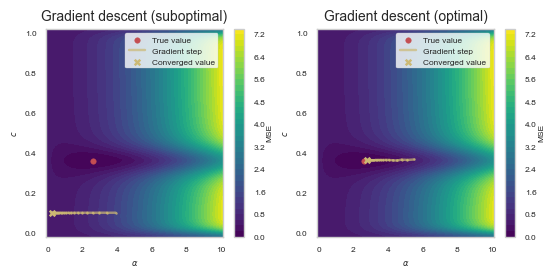

In [25]:

true_a = y[3].item()
true_c = y[0].item()/500
x_ = f(torch.tensor([true_a]), torch.tensor([true_c]))

# rcparams colors 
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# plot mse for different alpha and c values gradient plot 
a_lin = torch.linspace(-0.1, 10.1, 100)
c_lin = torch.linspace(-0.02, 1.02, 100)
A, C = torch.meshgrid(a_lin, c_lin)
mse = torch.zeros_like(A)
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        mse[i, j] = torch.mean((x_ - f(A[i, j], C[i, j]))**2)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
change_fig_size(fig, 12)


for i, vals in enumerate(values):
    ax = axs[i]
    contour_plot = ax.contourf(A, C, mse, levels=40 ,cmap="viridis")
    ax.set_xlabel("$\\alpha$")
    ax.set_ylabel("$c$")
    ax.set_title("Gradient descent " + ("(suboptimal)" if i == 0 else "(optimal)"))
    # colorbar on the right
    fig.colorbar(contour_plot, ax=ax)
    # color bar text    
    ax.text(13.0, 0.5, "MSE", rotation=90, va="center", ha="right")
    # plot point of convergence
    # true_a = true_y[3]
    # true_c = true_y[0]
    ax.scatter(true_a, true_c, color=colors[2], label="True value")
    # ax.scatter(a.detach().numpy(), c.detach().numpy(), color=colors[4], label="Converged value", marker="x")
    # draw line segments between points in vals
    for i in range(len(vals)-1):
        ax.plot([vals[i][0], vals[i+1][0]], [vals[i][1], vals[i+1][1]], color=colors[4], linestyle="-", alpha=0.7, label="Gradient step" if i == 0 else None)
        ax.scatter(vals[i][0], vals[i][1], color=colors[4], s=2, alpha=0.7)

    ax.scatter(vals[-1][0], vals[-1][1], color=colors[4], label="Converged value", marker="x")

    # legend 
    ax.legend(frameon=True)

plt.tight_layout()
path_to_save = os.path.join(report_dir, "figures", "results", "0_baseline", "gradient_descent_optimal_vs_suboptimal")
save_plot(plt, path_to_save, extensions=["png", "pdf"])
plot = plt
plot.show()